In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, train_test_split
import pandas as pd

import utils.load_data as ld
import utils.load_SAM40_data as ld_SAM40
import utils.features as f
import utils.classifiers as clfs
import utils.variables as v
import utils.metrics as m

2023-05-05 12:47:19.865086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_and_shape_data(data_type, label_type, feature, kfold, new_ica = False):
    #Load data
    if kfold:
        train_data, test_data, train_labels, test_labels = ld.load_kfold_data(data_type, label_type, epoched = False, binary = True)
    else:
        train_data, test_data, val_data, train_labels, test_labels, val_labels = ld.load_data(data_type, label_type, epoched = True, binary = True)
        return train_data, test_data, val_data, train_labels, test_labels, val_labels
    
    print('\n---- Balanced dataset? ----')
    print(f'Section of non-stressed in train set: {np.sum(train_labels == 0)/len(train_labels)}')
    print(f'Section of non-stressed in test set: {np.sum(test_labels == 0)/len(test_labels)}')


    if feature:
        #Reshape labels to fit (n_recordings*n_channels, 1)
        train_labels = np.repeat(train_labels, repeats = v.NUM_CHANNELS, axis = 0).reshape((train_data.shape[0]*v.NUM_CHANNELS,1))
        train_labels = train_labels.ravel()

        test_labels = np.repeat(test_labels,repeats = v.NUM_CHANNELS, axis = 0).reshape((test_data.shape[0]*v.NUM_CHANNELS,1))
        test_labels = test_labels.ravel()
        
        #Extract features
        #time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
        train_data = f.time_series_features(train_data, new_ica)
        test_data = f.time_series_features(test_data, new_ica)

        return train_data, test_data, train_labels, test_labels
    else:
        #Reshape data
        train_data = np.reshape(train_data, (train_data.shape[0]*train_data.shape[1], train_data.shape[2]))
        train_labels = np.repeat(train_labels, repeats = 8, axis = 1).reshape(-1,1)
        train_labels = train_labels.ravel()

        test_data = np.reshape(test_data, (test_data.shape[0]*test_data.shape[1],test_data.shape[2]))
        test_labels = np.repeat(test_labels, repeats = 8, axis = 1).reshape(-1,1)
        test_labels = test_labels.ravel()
        return train_data, test_data, train_labels, test_labels



In [3]:
def load_and_shape_psd_data(label_type):
    train_data, test_data, train_labels, test_labels = ld.load_psd_data(label_type, binary = True)
    train_data = np.reshape(train_data, (train_data.shape[0]*train_data.shape[1], train_data.shape[2]))
    train_labels = np.repeat(train_labels, repeats = 8, axis = 1).reshape(-1,1)
    train_labels = train_labels.ravel()

    test_data = np.reshape(test_data, (test_data.shape[0]*test_data.shape[1],test_data.shape[2]))
    test_labels = np.repeat(test_labels, repeats = 8, axis = 1).reshape(-1,1)
    test_labels = test_labels.ravel()
    
    return train_data, test_data, train_labels, test_labels

In [4]:
def load_and_shape_SAM40_data():
    #Load the SAM40 dataset to be used as test data/label
    selected_channels_names = ['Fp2', 'F4', 'FC6', 'T8', 'Oz', 'O1', 'C3', 'FT9']
    dataset_SAM40_ = ld_SAM40.load_dataset('raw', 'Arithmetic')
    channels = ld_SAM40.load_channels()

    #Extract only the same channels
    selected_chan_index = [channels.index(elem) for elem in selected_channels_names]
    selected_channels_dataset = np.array([dataset_SAM40_[:,i,:] for i in selected_chan_index])
    selected_channels_dataset = np.reshape(selected_channels_dataset, (120,8,3200))

    #Compute time_series_features for SAM40
    test_data_SAM40 = f.time_series_features(selected_channels_dataset, False, SAM40=True)

    #Load SAM40 labels 
    labels_ = ld_SAM40.load_labels()
    labels = pd.concat([labels_['t1_math'], labels_['t2_math'],
                    labels_['t3_math']]).to_numpy()
    
    #Change labels from T/F to 1/0
    for i in range(len(labels)):
        if labels[i]:
            labels[i] = 1
        else:
            labels[i] = 0

    test_labels_SAM40 = np.repeat(labels, test_data_SAM40.shape[0]//labels.shape[0])

    print(f'SAM40 test data shape: {test_data_SAM40.shape}')
    print(f'SAM40 test labels shape: {test_labels_SAM40.shape}')
    return test_data_SAM40, test_labels_SAM40

In [5]:
data_type = 'raw'
label_type = 'stai'
feature = True
kfold = True


train_data, test_data, train_labels, test_labels = load_and_shape_data(data_type, label_type, feature, kfold)

---- Generating all recordings ----
All records generated

---- Filtering out invalid recordings ----
ERROR 1) Failed to read data for recording P006_S002_001
ERROR 1) Failed to read data for recording P006_S002_002
ERROR 1) Failed to read data for recording P028_S002_001
ERROR 1) Failed to read data for recording P028_S002_002

---- Returning valid recordings ----
['P001_S001_001', 'P001_S001_002', 'P001_S002_001', 'P001_S002_002', 'P002_S001_001', 'P002_S001_002', 'P002_S002_001', 'P002_S002_002', 'P003_S001_001', 'P003_S001_002', 'P003_S002_001', 'P003_S002_002', 'P004_S001_001', 'P004_S001_002', 'P004_S002_001', 'P004_S002_002', 'P005_S001_001', 'P005_S001_002', 'P005_S002_001', 'P005_S002_002', 'P006_S001_001', 'P006_S001_002', 'P007_S001_001', 'P007_S001_002', 'P007_S002_001', 'P007_S002_002', 'P008_S001_001', 'P008_S001_002', 'P008_S002_001', 'P008_S002_002', 'P009_S001_001', 'P009_S001_002', 'P009_S002_001', 'P009_S002_002', 'P010_S001_002', 'P010_S002_001', 'P010_S002_002', 'P

SFREQ:  128
12
266
Features shape: (960, 798)
SAM40 test data shape: (960, 798)
SAM40 test labels shape: (960,)
Scaling training and testing data
Scaling SAM40 data
Finding the best model
SVC(C=0.01, kernel='linear')
{'C': 0.01, 'kernel': 'linear'}
Predicting on test data
Number of results: 40
accuracies: [0.73333333 0.6        0.6        0.6        0.74166667 0.59791667
 0.6        0.6        0.68333333 0.59375    0.6        0.58333333
 0.68541667 0.5875     0.6        0.5375     0.68541667 0.59791667
 0.70416667 0.50833333 0.68541667 0.59791667 0.725      0.50208333
 0.68541667 0.59583333 0.70833333 0.55208333 0.68541667 0.5875
 0.71458333 0.53541667 0.68541667 0.57708333 0.68958333 0.51458333
 0.68541667 0.57708333 0.68125    0.53958333]


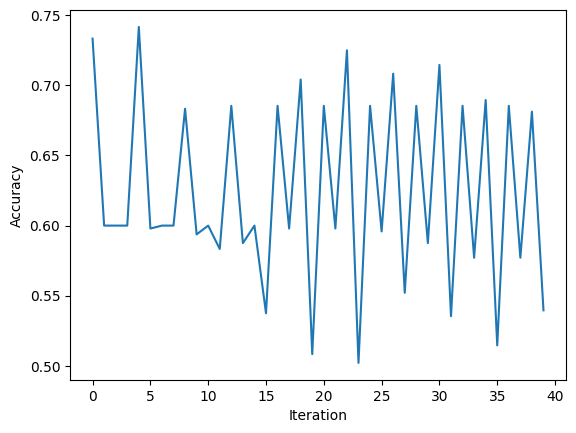

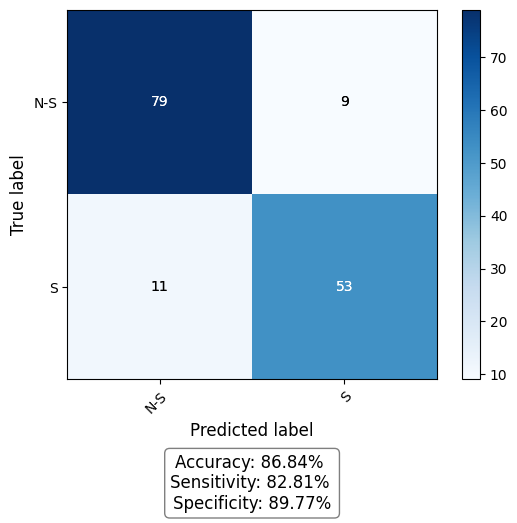

Predicting on SAM40 data


ValueError: X has 798 features, but SVC is expecting 9000 features as input.

In [6]:
SAM40_data, SAM40_labels = load_and_shape_SAM40_data()

clfs.svm_classification_SAM40(train_data, test_data, SAM40_data, train_labels, test_labels, SAM40_labels)

In [ ]:
print(f'{data_type} data with {label_type} labels')
#clfs.knn_classification(train_data, test_data, train_labels, test_labels)

In [ ]:
print(f'{data_type} data with {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)
